In [68]:
import pandas as pd
from tqdm import tqdm
import geopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.style.use('ggplot')

In [24]:
file_path = "D:\\hippo\\Documents\\PYTHON\\DATA\\gouv\\"
file_name = "dvf-communes-2019.csv"
df = pd.read_csv(file_path+file_name,sep=";")

In [25]:
df.head()

,ID,INSEE_COM,INSEE_DEP,INSEE_REG,CODE_EPCI,NOM_COM_M,POPULATION,Nb_Ventes,PrixMoyen_M2
0,COMMUNE_0000000009760754,32216,32,76,200072320.0,LOURTIES MONBRUN,152,NaN,NaN
1,COMMUNE_0000000009756744,47033,47,75,200036523.0,BOUDY DE BEAUREGARD,412,4.0,1421.0
2,COMMUNE_0000000009760252,32009,32,76,243200425.0,ARMOUS ET CAU,86,NaN,NaN
3,COMMUNE_0000000009754403,38225,38,84,243801024.0,AUTRANS MEAUDRE EN VERCORS,2969,47.0,2667.0
4,COMMUNE_0000000009727903,62890,62,32,200044030.0,WILLEMAN,182,3.0,967.0


In [30]:
df.shape

(26774, 9)

There are 34886 entries in the dataframe corresponding to the number of metropolitan municipalities.
Some of them have no data.

In [27]:
df.describe()

,INSEE_REG,CODE_EPCI,POPULATION,Nb_Ventes,PrixMoyen_M2
count,34886.000000,3.483700e+04,3.488600e+04,26822.000000,26822.000000
mean,52.462420,2.127412e+08,1.950264e+03,24.576243,1635.830177
std,24.216652,2.013492e+07,1.540069e+04,128.963903,864.263847
min,11.000000,2.000002e+08,0.000000e+00,1.000000,350.000000
25%,28.000000,2.000659e+08,1.990000e+02,2.000000,1101.000000
50%,44.000000,2.000696e+08,4.540000e+02,5.000000,1449.500000
75%,76.000000,2.412007e+08,1.147000e+03,13.000000,1933.000000
max,94.000000,2.495005e+08,2.190327e+06,7411.000000,14803.000000


There were 26774 sell in 2019. For a mean price of 1627€/m².

Renaming the columns to simplify access and understanding

In [31]:
df.columns=['ID','CP','DEPT','REGION','EPCI','NOM','POPULATION','VENTES','PRIX']

In [32]:
df.head()

,ID,CP,DEPT,REGION,EPCI,NOM,POPULATION,VENTES,PRIX
1,COMMUNE_0000000009756744,47033,47,75,200036523.0,BOUDY DE BEAUREGARD,412,4.0,1421.0
3,COMMUNE_0000000009754403,38225,38,84,243801024.0,AUTRANS MEAUDRE EN VERCORS,2969,47.0,2667.0
4,COMMUNE_0000000009727903,62890,62,32,200044030.0,WILLEMAN,182,3.0,967.0
5,COMMUNE_0000000009732421,8018,8,44,240800920.0,ARDEUIL ET MONTFAUXELLES,70,2.0,945.0
7,COMMUNE_0000000009741242,10319,10,44,241000447.0,RIGNY LE FERRON,366,9.0,678.0


Updating our dataframe to exclude NaN values and creating a backup df with all data

In [28]:
df_all_data = df
with_na = df.shape[0]
df = df.dropna()
without_na = df.shape[0]
print(f"{with_na-without_na} rows deleted!")

8112 rows deleted!


We now want to see in which cities did the most sales take place and where were the biggest deals.

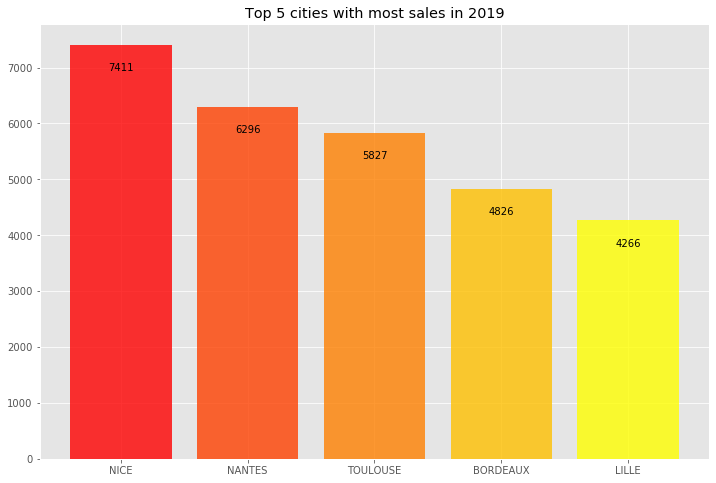

In [120]:
max_sales = df[['NOM','VENTES']].sort_values('VENTES',ascending=False)[:5]

fig,ax = plt.subplots(figsize=(12,8))
colors = cm.autumn(np.linspace(0,1,len(max_ventes['NOM'])))
bar = ax.bar(max_ventes['NOM'],max_ventes['VENTES'],color=colors,alpha=.8)

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.0, height-500, int(height),c='k', ha='center', va='bottom')

plt.title("Top 5 cities with most sales in 2019")
plt.show()

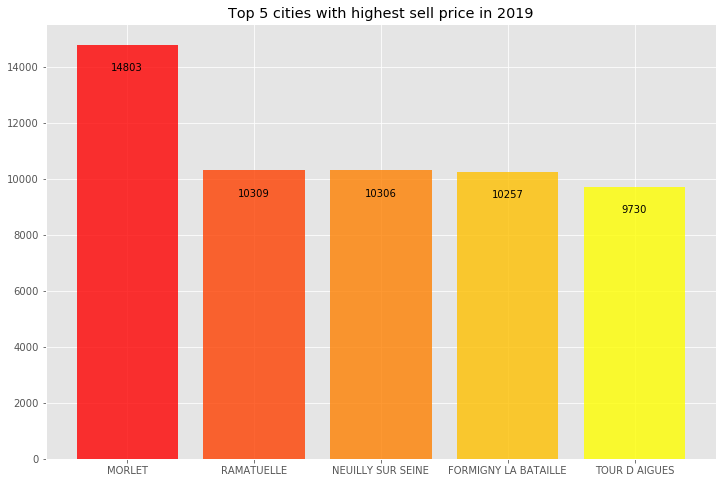

In [119]:
max_price = df[['NOM','PRIX']].sort_values('PRIX',ascending=False)[:5]
mean_price = df['PRIX'].mean()
fig,ax = plt.subplots(figsize=(12,8))
colors = cm.autumn(np.linspace(0,1,len(max_ventes['NOM'])))
bar = ax.bar(max_price['NOM'],max_price['PRIX'],color=colors,alpha=.8)
mean = ax.plot(mean_price)

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.0, height-1000, int(height),c='k', ha='center', va='bottom')

plt.title("Top 5 cities with highest sell price in 2019")
plt.show()

###  Even if these graphs looks great, they might not be as relevant as possible we rather want to see the price per sale.

Need to work on this to add (lat,lon) for each row ! 

In [167]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="dvf_2019_notebook")
location = geolocator.geocode("Ambierle")
list_lat = pd.Series(list(map(lambda x :(geolocator.geocode(x).latitude, geolocator.geocode(x).longitude),df['NOM'][:5])))
list_lat_lon

GeocoderTimedOut: Service timed out